# <div style="text-align: center"> <font size=+5> <ins>PREPARE DATASETS</ins> </font> </div>
___

# Imports and settings

In [2]:
#imports

import numpy as np
import pandas as pd
from pickle import dump, load
import gzip
import re

In [3]:
#settings

pd.set_option('display.max_columns', 500)

___
# Preparing questionnaires data

needs `pyreadstat` module

In [4]:
#load raw data

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    raw_data_issp = {
        1993 : pd.read_spss("../Raw_Data/Datasets_questions/issp_env_data_1993.sav"),
        2000 : pd.read_spss("../Raw_Data/Datasets_questions/issp_env_data_2000.sav"),
        2010 : pd.read_spss("../Raw_Data/Datasets_questions/issp_env_data_2010.sav"),
        2020 : pd.read_spss("../Raw_Data/Datasets_questions/issp_env_data_2020.sav"),
    }

In [5]:
#setup income columns (some conversions in 2000; in 2010 and 2020 income has a country specific column with different formatting and units)


# 2000
conv_2000_income_dict = {'J:in thous. Yen' : np.nan, 'NIRL: 40 000 Pounds + (per annum)' : 4e4, 'E,N,RCH,USA: > 1.000.000' : 1e6 , 'RUS: 100 new RUR' : 1e2}
raw_data_issp[2000]["V240"] = raw_data_issp[2000]["V240"].map(lambda x: x if x not in conv_2000_income_dict else conv_2000_income_dict[x])



# 2010 - 2020
income_conv_regex = {
    2010 : [
            r"\d{1,3}(?:\.\d{3})*\ ?\-\ ?(?P<value>\d{1,3}(?:\.\d{3})*)[^\d]+", #second value in range
            r"^[^\d]*?(?P<value>\d{1,3}(?:\.\d{3})*)[^\d]+" #first value in string
        ],
    2020 : [
            #country specific
            r"\d{1,3}(?:\ ?\d{3})*\ up\ to\ less\ than\ (?P<value>\d{1,3}(?:\ ?\d{3})*) CHF",
            r"\d{1,3}(?:(\ |\.)\d{3})*\ ?\–\ ?(?P<value>\d{1,3}(?:(\ |\.)?\d{3})*)[^\d]+", #careful -> `–` in NZ data is a different char than regular `-` dash (what a smart idea!)
            r"^(?P<value>\d{1,3}\ 000) RUB.*",
            
            #all
            r"\d{1,3}(?:(\ |\.)\d{3})*\ ?\-\ ?(?P<value>\d{1,3}(?:(\ |\.)?\d{3})*)[^\d]+", #second value in range
            r"^[^\d]*?(?P<value>\d{1,3}(?:(\ |\.)?\d{3})*)[^\d]+" #first value in string
        ]
}
    
def get_income(value, year):
    if value in ["No own income, not in paid work", "No income", "No own income", "No personal income", "Loss/ Zero income", "Have no income, fully dependent on husband/ wife or others", "No income (e.g. working for a family business, but no salary)", "No income (earned from job last year)"]:
        return "0" #zero or np.nan??
    elif isinstance(value, (int, float)):
        return value
    elif isinstance(value, str):
        for pattern in income_conv_regex[year]:
            match = re.search(pattern, value)
            if match:
                if year == 2010:
                    return match.group("value").replace(".", "")
                if year == 2020:
                    return match.group("value").replace(" ", "").replace(".", "")
                
        raise RuntimeError("regex match failed")
    else:
        raise RuntimeError("unrecognised value type")
        
for year in [2010, 2020]:
    c = [c for c in raw_data_issp[year].columns if c[-4:] == "RINC"]
    srs = [raw_data_issp[year].loc[:,col].dropna().map(lambda x: get_income(x, year)).astype(float) for col in c]
    raw_data_issp[year]["RINC"] = pd.concat(srs, axis=0)

del(income_conv_regex, get_income, conv_2000_income_dict)

### Selecting Variables

In [6]:
#get specific columns from raw data



################################  merged dataset - all years  ################################
common_questions_issp = {
    #format:
    # "q_name" : {1993 : "var_number", 2000 : "var_number", 2010 : "var_number", 2020 : "var_number"}
    
    #"Private enterprise solves economic problems" : {1993 : "V5", 2000 : "V4", 2010 : "v7", 2020 : "v3"}, #not related to environment
    #"Government responsible for reducing income differences" : {1993 : "V6", 2000 : "V5", 2010 : "v8", 2020 : "v4"}, #not related to environment
    #"Highest priority for country" : {1993 : "V7", 2000 : "V6", 2010 : "v9", 2020 : "v8"}, #not related to environment
    #"Second highest priority for country" : {1993 : "V8", 2000 : "V7", 2010 : "v10", 2020 : "v9"}, #not related to environment
    "Science solves environmental problems" : {1993 : "V12", 2000 : "V10", 2010 : "v22", 2020 : "v20"},
    "We worry too much about future environment" : {1993 : "V13", 2000 : "V11", 2010 : "v23", 2020 : "v21"},
    "We worry too much about harming environment" : {1993 : "V17", 2000 : "V13", 2010 : "v25", 2020 : "v23"},
    "Almost everything in modern life harms the environment" : {1993 : "V14", 2000 : "V12", 2010 : "v24", 2020 : "v22"},
    "Environmental protection needs economic growth" : {1993 : "V19", 2000 : "V14", 2010 : "v26", 2020 : "v24"},
    "Economic growth harms environment" : {1993 : "V22", 2000 : "V16", 2010 : "v27", 2020 : "v25"},
    "Willingness to Make Trade-Offs for Environment (Pay much higher prices)" : {1993 : "V24", 2000 : "V19", 2010 : "v29", 2020 : "v26"},
    "Willingness to Make Trade-Offs for Environment (Pay much higher taxes)" : {1993 : "V25", 2000 : "V20", 2010 : "v30", 2020 : "v27"},
    "Willingness to Make Trade-Offs for Environment (Cut your standard of living)" : {1993 : "V26", 2000 : "V21", 2010 : "v31", 2020 : "v28"},
    "Sort glass for recycling" : {1993 : "V56", 2000 : "V56", 2010 : "v55", 2020 : "v52"},
    "Member of a group to preserve environment" : {1993 : "V60", 2000 : "V58", 2010 : "v61", 2020 : "v54"},
    "In the last five years, signed a petition" : {1993 : "V61", 2000 : "V59", 2010 : "v62", 2020 : "v55"},
    "In the last five years, given money" : {1993 : "V62", 2000 : "V60", 2010 : "v63", 2020 : "v56"},
    "In the last five years, participated in an environmental demonstration" : {1993 : "V63", 2000 : "V61", 2010 : "v64", 2020 : "v57"},
    "Too difficult to do much about environment" : {1993 : "V27", 2000 : "V22", 2010 : "v32", 2020 : "v30"},
    "I do what is right even when it costs money and takes time" : {1993 : "V28", 2000 : "V23", 2010 : "v33", 2020 : "v31"},
    "Danger to the environment (Air pollution by cars)" : {1993 : "V41", 2000 : "V33", 2010 : "v39", 2020 : "v37"},
    "Danger to the environment (Air pollution by industry)" : {1993 : "V46", 2000 : "V35", 2010 : "v40", 2020 : "v38"},
    "Danger to the environment (Pesticides and chemicals in farming)" : {1993 : "V48", 2000 : "V36", 2010 : "v41", 2020 : "v39"},
    "Danger to the environment (River, lake and stream pollution)" : {1993 : "V50", 2000 : "V37", 2010 : "v42", 2020 : "v40"},
    "Danger to the environment (Rise in the world’s temperature)" : {1993 : "V52", 2000 : "V38", 2010 : "v43", 2020 : "v41"},
    "Danger to the environment (Nuclear power stations)" : {1993 : "V44", 2000 : "V64", 2010 : "v45", 2020 : "v43"},
    #"" : {1993 : "V", 2000 : "V", 2010 : "v", 2020 : "v"},
}

common_respondentData_issp = {
    #"Respondent ID" : {1993 : "V2", 2000 : "V2", 2010 : "CASEID", 2020 : "CASEID"}, #not really useful, also seems to have duplicates (!?)
    "Weight" : {1993 : "V419", 2000 : "V327", 2010 : "WEIGHT", 2020 : "WEIGHT"},
    "Country" : {1993 : "V3", 2000 : "V3", 2010 : "country", 2020 : "country"},
    "Sex" : {1993 : "V200", 2000 : "V200", 2010 : "SEX", 2020 : "SEX"},
    "Age" : {1993 : "V201", 2000 : "V201", 2010 : "AGE", 2020 : "AGE"},
    "Education level" : {1993 : "V205", 2000 : "V205", 2010 : "DEGREE", 2020 : "EDULEVEL"},
    #"Education Years" : {1993 : "V204", 2000 : "V204", 2010 : "EDUCYRS", 2020 : "EDUCYRS"}, #may be used, not great formatting (TODO)
    "Personal income" : {1993: "V231", 2000 : "V240", 2010 : "RINC", 2020 : "RINC"}, #horrible formatting, but fixed in cell above :)
    "Living area" : {1993: "V65", 2000 : "V63", 2010 : "URBRURAL", 2020 : "URBRURAL"},
    "Political orientation" : {1993: "V281", 2000 : "V246", 2010 : "PARTY_LR", 2020 : "PARTY_LR"},
    "Religious beliefs" : {1993: "V276", 2000 : "V242", 2010 : "RELIGGRP", 2020 : "RELIGGRP"},
    #"" : {1993: "", 2000 : "", 2010 : "", 2020 : ""},
}



################################ yearly datasets - additional variables ################################

yearly_questions_issp = {
    # format:
    # year : {"q_name" : "var_number",
    #   }
    1993 :  {
        },
    2000 :  {"More important things than protecting environment" : "V24",
        },
    2010 :  {"Most important issue" : "v5",
             "How concerned in environmental issues" : "v15",
             "More important things than protecting environment" : "v34",
             "Trust in people" : "v11"
        },
    2020 :  {"Most important issue" : "v1",
             "How concerned in environmental issues" : "v15",
             "More important things than protecting environment" : "v32",
             "Trust in people" : "v10",
             "How many days/week eat meat" : "v50"
        }
}


yearly_respondentData_issp = {
    1993 :  {
        },
    2000 :  {
        },
    2010 :  {
        },
    2020 :  {
        }
}

### Preprocessing and dumping datasets

In [12]:
#preprocessing

data_filtered_issp = {year : pd.DataFrame() for year in [1993, 2000, 2010, 2020]}
for year in data_filtered_issp:
    for col, col_idx in {**{q : v[year] for q,v in common_questions_issp.items()}, **{q : v[year] for q,v in common_respondentData_issp.items()}, **(yearly_questions_issp[year]), **(yearly_respondentData_issp[year])}.items():
        data_filtered_issp[year][col] = raw_data_issp[year][col_idx]


######## match country names for different years ############################################################################################
countries_codes_issp = {
    1993 : {
        'Australia - AUS' : "Australia",
        'Bulgaria - BG' : "Bulgaria",
        'Canada - CDN' : "Canada",
        'Czech Republic - CR' : "Czechia",
        'Germany-East - D-E' : "Germany",
        'Germany-West - D-W' : "Germany",
        'Great Britain - GB' : "United Kingdom",
        'Hungary - H' : "Hungary",
        'Ireland - IRL' : "Ireland",
        'Israel - IL' : "Israel", 
        'Italy - I' : "Italy",
        'Japan - J' : "Japan",
        'Netherlands - NL' : "Netherlands",
        'New Zealand - NZ' : "New Zealand",
        'Northern Ireland - NIRL' : "United Kingdom",
        'Norway - N' : "Norway",
        'Philippines - RP' : "Philippines",
        'Poland - PL' : "Poland",
        'Russia - RUS' : "Russia",
        'Slovenia - SLO' : "Slovenia",
        'Spain - E' : "Spain",
        'United States - USA' : "United States"
    },

    2000 : {
        'A-Austria' : "Austria",
        'BG-Bulgaria' : "Bulgaria",
        'CDN-Canada' : "Canada",
        'CH-Switzerland' : "Switzerland",
        'CZ-Czech Republic' : "Czechia",
        'D-E-Germany-East' : "Germany",
        'D-W-Germany-West' : "Germany",
        'DK-Denmark' : "Denmark",
        'E-Spain' : "Spain",
        'GB-Great Britain' : "United Kingdom",
        'IL-Israel' : "Israel",
        'IRL-Ireland' : "Ireland",
        'J-Japan' : "Japan",
        'LV-Latvia' : "Latvia",
        'MEX-Mexico' : "Mexico",
        'N-Norway' : "Norway",
        'NIRL-Northern Ireland' : "United Kingdom",
        'NL-Netherlands' : "Netherlands",
        'NZ-New Zealand' : "New Zealand",
        'P-Portugal' : "Portugal",
        'RCH-Chile' : "Chile",
        'RP-Philippines' : "Philippines",
        'RUS-Russia' : "Russia",
        'S-Sweden' : "Sweden",
        'SF-Finland' : "Finland",
        'SLO-Slovenia' : "Slovenia",
        'USA-United States' : "United States"
    },

    2010 : {
        'AR-Argentina' : "Argentina",
        'AT-Austria' : "Austria",
        'AU-Australia' : "Australia",
        'BE-Belgium' : "Belgium",
        'BG-Bulgaria' : "Bulgaria",
        'CA-Canada' : "Canada",
        'CH-Switzerland' : "Switzerland",
        'CL-Chile' : "Chile",
        'CZ-Czech Republic' : "Czechia",
        'DE-Germany' : "Germany",
        'DK-Denmark' : "Denmark",
        'ES-Spain' : "Spain",
        'FI-Finland' : "Finland",
        'FR-France' : "France",
        'GB-Great Britain and/or United Kingdom' : "United Kingdom",
        'HR-Croatia' : "Croatia",
        'IL-Israel' : "Israel",
        'IS-Iceland' : "Iceland",
        'JP-Japan' : "Japan",
        'KR-Korea (South)' : "South Korea",
        'LT-Lithuania' : "Lithuania",
        'LV-Latvia' : "Latvia",
        'MX-Mexico' : "Mexico",
        'NL-Netherlands' : "Netherlands",
        'NO-Norway' : "Norway",
        'NZ-New Zealand' : "New Zealand",
        'PH-Philippines' : "Philippines",
        'PT-Portugal' : "Portugal",
        'RU-Russia' : "Russia",
        'SE-Sweden' : "Sweden",
        'SI-Slovenia' : "Slovenia",
        'SK-Slovakia' : "Slovakia",
        'TR-Turkey' : "Turkiye",
        'TW-Taiwan' : "China",
        'US-United States' : "United States",
        'ZA-South Africa' : "South Africa"
    },

    2020 : {
        'AT-Austria' : "Austria",
        'AU-Australia' : "Australia",
        'CH-Switzerland' : "Switzerland",
        'CN-China' : "China",
        'DE-Germany' : "Germany",
        'DK-Denmark' : "Denmark",
        'ES-Spain' : "Spain",
        'FI-Finland' : "Finland",
        'FR-France' : "France",
        'HR-Croatia' : "Croatia",
        'HU-Hungary' : "Hungary",
        'IN-India' : "India",
        'IS-Iceland' : "Iceland",
        'IT-Italy' : "Italy",
        'JP-Japan' : "Japan",
        'KR-Korea (South)' : "South Korea",
        'LT-Lithuania' : "Lithuania",
        'NO-Norway' : "Norway",
        'NZ-New Zealand' : "New Zealand",
        'PH-Philippines' : "Philippines",
        'RU-Russia' : "Russia",
        'SE-Sweden' : "Sweden",
        'SI-Slovenia' : "Slovenia",
        'SK-Slovakia' : "Slovakia",
        'TH-Thailand' : "Thailand",
        'TW-Taiwan' : "China",
        'US-United States' : "United States",
        'ZA-South Africa' : "South Africa"
    }
}

for year in data_filtered_issp:
    data_filtered_issp[year]["Country"] = data_filtered_issp[year]["Country"].map(lambda x: countries_codes_issp[year][x])

del(countries_codes_issp)



######## fix data without weight (set to 1) #################################################################################################
for year in data_filtered_issp:
    data_filtered_issp[year]["Weight"] = data_filtered_issp[year]["Weight"].map(lambda x: 1 if isinstance(x, str) else x)



######## fix age values formatting ##########################################################################################################
labels_age = {
	"15 years" : 15,
	"97 years" : 97,
	"GB:18 yrs or above" : 18,
	"GB:96 yrs or older" : 96,
	"16 years" : 16,
	"US: 89 and older" : 89,
	"99 years" : 99,
	"89 years old; US: 89 years or more" : 89,
	"103 years old" : 103,
	"15 years old" : 15,
}

for year in data_filtered_issp:
    data_filtered_issp[year]["Age"] = data_filtered_issp[year]["Age"].map(lambda x: labels_age[x] if x in labels_age else x).astype(float)

del(labels_age)



######## fix living area formatting #########################################################################################################
labels_livingArea = {
	"Suburbs of big city" : "Big city",
	"Big city" : "Big city",
	"Small city or town" : "Small city",
	"Country village" : "Small city",
	"Farm, home in the country" : "Rural area",
	"H: City-count-seat" : "Small city",
	"A big city" : "Big city",
	"The suburbs or outskirts of a big city" : "Big city",
	"A town or a small city" : "Small city",
	"A country village" : "Rural area",
	"A farm or home in the country" : "Rural",
	"GB-GBN: other answer" : np.nan,
}

for year in data_filtered_issp:
    data_filtered_issp[year]["Living area"] = pd.Categorical(data_filtered_issp[year]["Living area"].map(lambda x: labels_livingArea[x] if x in labels_livingArea else x), ["Big city", "Small city", "Rural area"])

del(labels_livingArea)



######## fix political orientation lables ###################################################################################################
labels_politicalOrientation = {
	"Left,center left" : "Left",
	"Right,conservative" : "Right",
	"Center,liberal" : "Center",
	"No party; would n vote" : "None/Other",
	"Other,no specific" : "None/Other",
	"Far right etc" : "Far Right",
	"Far left etc" : "Far Left",
	"No party,no preference" : "None/Other",
	"No party affiliation, no preference, would not vote" : "None/Other",
	"Left, center left" : "Left",
	"Center, liberal" : "Center",
	"Right, conservative" : "Right",
	"Far left (communist etc.)" : "Far Left",
	"Far right (fascist etc.)" : "Far Right",
	"Other, no specification" : "None/Other",
	"Far left (communist, etc.)" : "Far Left",
	"Right / conservative" : "Right",
	"Left / center left" : "Left",
	"Far right (fascist, etc.)" : "Far Right",
	"Center / liberal" : "Center",
	"Other" : "None/Other",
	"Invalid ballot" : "None/Other",
}

for year in data_filtered_issp:
    data_filtered_issp[year]["Political orientation"] = pd.Categorical(data_filtered_issp[year]["Political orientation"].map(lambda x: labels_politicalOrientation[x] if x in labels_politicalOrientation else x), ["Far Left", "Left", "Center", "Right", "Far Right", "None/Other"])

del(labels_politicalOrientation)



######## fix education level categories - match lables ######################################################################################
labels_edu = {
    "Primary compl": "Primary",
    "Incpl secondary": "Primary",
    "University compl": "University",
    "Secondary compl": "Secondary",
    "Incpl primary": "No degree",
    "Incpl semi-higher": "No degree",
    "None": "No degree",
    "Incpl university": "Secondary",
    "Compl semi-higher": "Secondary",
    "None;still at school,uni" : "No degree",
    "Incpl secondary" : "Primary",
    "Primary compl" : "Primary",
    "University compl" : "University",
    "Secondary compl" : "Secondary",
    "Incpl primary" : "Primary",
    "Semi-higher,incompl uni." : "Secondary",
    "Intermediate secondary completed (qualifications above the lowest qualification)" : "Secondary",
    "University degree completed, BG: lower tertiary level, upper tertiary level" : "University",
    "No formal qualification" : "No degree",
    "University degree incomplete (qualifications above higher secondary level)" : "Secondary",
    "Higher secondary completed (usual entry requirements for universities)" : "Secondary",
    "Lowest formal qualification" : "Primary",
    "Short-cycle tertiary" : "University",
    "Upper secondary " : "Secondary",
    "Lower secondary " : "Primary",
    "Post secondary, non-tertiary" : "Secondary",
    "Upper tertiary, MA" : "University",
    "Lower tertiary, BA" : "University",
    "PhD, Post tertiary specialization" : "University",
    "Primary " : "Primary",
    "No , incomplete primary" : "No degree",
    "Upper secondary education" : "Secondary",
    "Lower secondary education" : "Secondary",
    "Primary education" : "Primary",
    "No education, incomplete primary" : "No degree",
}


for year in data_filtered_issp:
    data_filtered_issp[year]["Education level"] = pd.Categorical(data_filtered_issp[year]["Education level"].map(lambda x: labels_edu.get(x,x)), ["No degree", "Primary", "Secondary", "University"])

del(labels_edu)



######## fix religious beliefs categories ###################################################################################################
labels_relig = {
    "None" : "Atheist",
    "Ch Engl,Ire,Anglica" : "Christian",
    "Orthodox; Eastern Orthodox" : "Christian",
    "Catholic" : "Christian",
    "Buddhists" : "Other",
    "Unitarians" : "Christian",
    "Presbyt,Ch of Scot" : "Christian",
    "Methodist" : "Christian",
    "Baptist" : "Christian",
    "Prot (n else class)" : "Christian",
    "Oth christ religion" : "Christian",
    "Moslem" : "Islamic",
    "Lutheran" : "Christian",
    "Jewish" : "Jewish",
    "Other non-christian" : "Other",
    "Prot(ev)free church" : "Christian",
    "No denom given" : "Other",
    "Hindu" : "Other",
    "Sikh" : "Other",
    "URC/ Congregational" : "Christian",
    "Episcopal" : "Christian",
    "Greek Catholic" : "Christian",
    "Other n classified" : "Other",
    "United Ch CDN" : "Christian",
    "Brethren" : "Christian",
    "NZ: Ratana" : "Christian",
    "Shinto" : "Other",
    "Lutheran, evangelical church" : "Christian",
    "Roman Catholic" : "Christian",
    "Ch Engl,Ire,Anglican" : "Christian",
    "Muslim, Islam" : "Islamic",
    "Prot (n else class), reformated" : "Christian",
    "Pentecostal" : "Christian",
    "Brethren,CZech-Brethren" : "Christian",
    "GB:Free Presbytarian" : "Christian",
    "Mormon" : "Christian",
    "Salvation Army,Assemblies of God" : "Christian",
    "Seventh Day Adventists,Born again" : "Christian",
    "CZ:Hussites" : "Christia",
    "NZ:Ratana" : "Christian",
    "United Church CDN" : "Christian",
    "Unitarians,AUS:Uniting church" : "Christian",
    "RP:Aglipayan" : "Christian",
    "RCH:Jehovas Witness" : "Christian",
    "No religion, CL: none, agnostic, atheist" : "Atheist",
    "Protestant" : "Christian",
    "Buddhist" : "Other",
    "Other Christian" : "Christian",
    "Islamic" : "Islamic",
    "Other Religions" : "Other",
    "Christian Orthodox" : "Christian",
    "Other Asian Religions" : "Other",
    "No religion" : "Atheist",
    "Orthodox" : "Christian"
}

for year in data_filtered_issp:
    data_filtered_issp[year]["Religious beliefs"] = pd.Categorical(data_filtered_issp[year]["Religious beliefs"].map(lambda x: labels_relig[x] if x in labels_relig else x), ["Christian", "Islamic", "Jewish", "Atheist", "Other"])

del(labels_relig)




######## fix other labels not matching between different years ##############################################################################
labels_issp = {
    #agree/disagree
    "Neither agree nor disagree" : "Neither Agree nor Disagree",
    "N Agree Nor Disagr" : "Neither Agree nor Disagree",
    "Neither Agree Nor Disagree" : "Neither Agree nor Disagree",
    "Agree strongly" : "Strongly Agree",
    "Disagree strongly" : "Strongly Disagree",

    #willing/unwilling
    "Neither nor" : "Neither willing nor unwilling",

    #priorities
    "Order in Nation" : "Maintain order in the nation",
    "Order in the Nation" : "Maintain order in the nation",
    "People more say" : "Give people more say in government decisions",

    #glass recycling
    "Recycling nav" : "Never", #only 1993-2000 "recycling not available" -> converted to "never"

    #dangerous/not dangerous
    "Extrem danger enviroment" : "Extremely dangerous",
    "Extremely dangerous for the environment" : "Extremely dangerous",
    "Not dangerous at all for the environment" : "Not dangerous at all",

    #yes/no
    "Yes, I have" : "Yes",
    "No, I have not" : "No",
}

for year in data_filtered_issp:
    data_filtered_issp[year] = data_filtered_issp[year].map(lambda x: labels_issp[x] if x in labels_issp else x)

del(labels_issp)


######## fix categorical variables order for plotting #######################################################################################
for year in data_filtered_issp.keys():
    
    data_filtered_issp[year]["Sort glass for recycling"] = data_filtered_issp[year]["Sort glass for recycling"].astype("category")
    for col in data_filtered_issp[year].select_dtypes(include="category").columns.values:
    
        if "Agree" in data_filtered_issp[year][col].values:
            data_filtered_issp[year][col] = pd.Categorical(data_filtered_issp[year][col], ["Strongly Agree", "Agree", "Neither Agree nor Disagree", "Disagree", "Strongly Disagree"])
        
        if "Very willing" in data_filtered_issp[year][col].values:
            data_filtered_issp[year][col] = pd.Categorical(data_filtered_issp[year][col], ["Very willing", "Fairly willing", "Neither willing nor unwilling", "Fairly unwilling", "Very unwilling"])
        
        if "Extremely dangerous" in data_filtered_issp[year][col].values:
            data_filtered_issp[year][col] = pd.Categorical(data_filtered_issp[year][col], ["Extremely dangerous", "Very dangerous", "Somewhat dangerous", "Not very dangerous", "Not dangerous at all"])
        
        if "Yes" in data_filtered_issp[year][col].values:
            data_filtered_issp[year][col] = pd.Categorical(data_filtered_issp[year][col], ["Yes", "No"])
        
        if "Always" in data_filtered_issp[year][col].values:
            data_filtered_issp[year][col] = pd.Categorical(data_filtered_issp[year][col], ["Always", "Often", "Sometimes", "Never"])

    


######## normalize income by country for comparisons ########################################################################################
for year in data_filtered_issp:
    data_filtered_issp[year]["Personal income"] = data_filtered_issp[year]["Personal income"].astype(float)
    for country in data_filtered_issp[year]["Country"].unique():
        data_income = data_filtered_issp[year].loc[data_filtered_issp[year]["Country"] == country, "Personal income"].copy()
        data_income = (data_income - data_income.mean())/data_income.std()
        data_filtered_issp[year].loc[data_filtered_issp[year]["Country"] == country, "Personal income"] = data_income

In [13]:
#get full dataframe  --> varName: `data_issp_common`
data_issp_quest = pd.concat([df.loc[:,common_questions_issp.keys()] for df in data_filtered_issp.values()], keys=data_filtered_issp.keys())
data_issp_respData = pd.concat([df.loc[:,common_respondentData_issp.keys()] for df in data_filtered_issp.values()], keys=data_filtered_issp.keys())
data_issp_common = pd.concat([data_issp_respData, data_issp_quest], axis=1, keys=["Respondent Data", "Questions"]) 
data_issp_common[("Respondent Data","Year")] = [x[0] for x in data_issp_common.index]

data_issp_common = data_issp_common.sort_values([("Respondent Data", "Year"),("Respondent Data", "Country")])

data_issp_common = data_issp_common.reset_index(drop=True).reset_index()
data_issp_common = data_issp_common.set_index([("Respondent Data","Year"), ("Respondent Data","Country"), ("index","")])
data_issp_common.index = data_issp_common.index.rename(["Year", "Country", "Unique ID"])

data_issp_common.columns = data_issp_common.columns.rename(["Variable Type", "Variable Name"])

del (data_issp_quest, data_issp_respData)

#dump to file
#data_issp_common.to_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

In [14]:
#get dataframes for each year --> varName: `data_issp_yearly[year]`
data_issp_yearly = {}
for year in data_filtered_issp.keys():
    
    questions = list({**common_questions_issp, **yearly_questions_issp[year]}.keys())
    respData = list({**common_respondentData_issp, **yearly_respondentData_issp[year]}.keys())

    data_issp_quest = data_filtered_issp[year].loc[:, questions]
    data_issp_respData = data_filtered_issp[year].loc[:, respData]
    
    data = pd.concat([data_issp_respData, data_issp_quest], axis=1, keys=["Respondent Data", "Questions"])

    data = data.sort_values(("Respondent Data", "Country")).reset_index(drop=True)
    
    data.index = pd.MultiIndex.from_arrays([data[("Respondent Data", "Country")], data.index], names=["Country", "Unique ID"])
    data.columns = data.columns.rename(("Variable Type", "Variable Name"))
    
    data_issp_yearly[year] = data.drop(columns=("Respondent Data", "Country"))

    del (data_issp_quest, data_issp_respData, data)

#dump to file
with gzip.open("../Processed_Data/questionnaires/issp_questionnaires_yearly.pickle", "wb") as file:
    #dump((data_issp_yearly[1993], data_issp_yearly[2000], data_issp_yearly[2010], data_issp_yearly[2020]), file)
    pass

___
# Preparing GDP growth data

In [55]:
#load raw data
raw_data_GDPgrowth = pd.read_csv("../Raw_Data/Economy/worldbank_gdp_growth.csv").drop(columns=["Country Code", "Indicator Code", "Indicator Name", "Unnamed: 67"])
raw_data_GDPgrowth.set_index("Country Name", drop=True, inplace=True)
raw_data_GDPgrowth.columns = raw_data_GDPgrowth.columns.astype(int)

In [56]:
#getting full dataframe --> varName: `data_GDPgrowth`
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

years_to_average = 3 #how many years to evaluate (years == 3 --> growth from 1990 to 1993, 1997 to 2000...)

data_GDPgrowth = pd.DataFrame()
for year in [1993,2000,2010,2020]:
    data_GDPgrowth[year] = ((1+0.01*raw_data_GDPgrowth.loc[:,year-years_to_average+1:year]).prod(axis=1)-1)*100

data_GDPgrowth = data_GDPgrowth.map(lambda x: np.nan if x == 0.0 else x)

countries_names_GDP = {
    "Russian Federation" : "Russia",
    "Korea, Rep." : "South Korea",
    "Slovak Republic" : "Slovakia",
}
data_GDPgrowth.index = data_GDPgrowth.index.map(lambda x: countries_names_GDP[x] if x in countries_names_GDP else x)
data_GDPgrowth.index.names = ["Country"]

data_GDPgrowth = data_GDPgrowth.loc[[idx in np.append(data_issp.index.get_level_values("Country").unique(), "World") for idx in data_GDPgrowth.index.values],:]

In [42]:
#dump to file
data_GDPgrowth.to_pickle("../Processed_Data/indicators/GDP_growth.pickle")

In [57]:
data_GDPgrowth

,1993,2000,2010,2020
Country,,,,
Argentina,27.462761,-0.457261,7.811201,-14.014327
Australia,4.091114,14.236093,7.896710,4.798938
Austria,6.163552,10.886097,-0.565379,-2.981319
Belgium,2.397289,9.497903,1.236110,-1.401144
Bulgaria,-16.360214,-0.563808,4.172696,2.601445
Canada,1.406095,14.847057,1.081879,-0.571476
Switzerland,-1.083924,8.889534,3.703965,1.806936
Chile,27.738763,9.061122,8.634479,-1.675123
China,42.132478,25.966473,32.714858,15.633863


___
# Preparing GDP per capita data

In [44]:
#load raw data
raw_data_GDP = pd.read_csv("../Raw_Data/Economy/worldbank_gdp_per_capita.csv").drop(columns=["Country Code", "Indicator Code", "Indicator Name", "Unnamed: 67"])
raw_data_GDP.set_index("Country Name", drop=True, inplace=True)
raw_data_GDP.columns = raw_data_GDP.columns.astype(int)

In [45]:
#getting full dataframe --> varName: `data_GDP`
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

data_GDP = raw_data_GDP[[1993,1995,2000,2010,2020]].copy()

#few countries don't have 1993 data --> using 1995
for c in data_GDP.index:
    if np.isnan(data_GDP.loc[c, 1993]):
        data_GDP.loc[c,1993] = data_GDP.loc[c,1995]
data_GDP = data_GDP.drop(columns=[1995])

countries_names_GDP = {
    "Russian Federation" : "Russia",
    "Korea, Rep." : "South Korea",
    "Slovak Republic" : "Slovakia",
}
data_GDP.index = data_GDP.index.map(lambda x: countries_names_GDP[x] if x in countries_names_GDP else x)
data_GDP.index.names = ["Country"]

data_GDP = data_GDP.loc[[idx in np.append(data_issp.index.get_level_values("Country").unique(), "World") for idx in data_GDP.index.values],:]

In [46]:
#dump to file
data_GDP.to_pickle("../Processed_Data/indicators/GDP_pcap.pickle")

In [47]:
data_GDP

,1993,2000,2010,2020
Country,,,,
Argentina,6957.417499,7666.517834,10385.964432,8500.837939
Australia,17699.557739,21870.415967,52147.024194,51868.247557
Austria,24081.527793,24625.600723,46903.761585,48789.497850
Belgium,22283.936021,23098.886508,44184.946354,45609.003494
Bulgaria,1278.525114,1621.262107,6863.667068,10148.342395
Canada,20186.798878,24271.002056,47562.083425,43562.435831
Switzerland,39237.118656,38865.021940,76531.372941,85897.784334
Chile,3520.932955,5102.968761,12764.593118,13173.784794
China,525.365692,959.360431,4550.473944,10408.719554


___
# Preparing GDP per capita (Purchasing Power Parity, current international $)

In [48]:
#load raw data
raw_data_GDP_PPP = pd.read_csv("../Raw_Data/Economy/worldbank_gdp_per_capita_PPP.csv").drop(columns=["Country Code", "Indicator Code", "Indicator Name", "Unnamed: 67"])
raw_data_GDP_PPP.set_index("Country Name", drop=True, inplace=True)
raw_data_GDP_PPP.columns = raw_data_GDP_PPP.columns.astype(int)

In [49]:
#getting full dataframe --> varName: `data_GDP_PPP`
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

data_GDP_PPP = raw_data_GDP_PPP[[1993,1995,2000,2010,2020]].copy()

#few countries don't have 1993 data --> using 1995
for c in data_GDP_PPP.index:
    if np.isnan(data_GDP_PPP.loc[c, 1993]):
        data_GDP_PPP.loc[c,1993] = data_GDP_PPP.loc[c,1995]
data_GDP_PPP = data_GDP_PPP.drop(columns=[1995])

countries_names_GDP_PPP = {
    "Russian Federation" : "Russia",
    "Korea, Rep." : "South Korea",
    "Slovak Republic" : "Slovakia",
}
data_GDP_PPP.index = data_GDP_PPP.index.map(lambda x: countries_names_GDP_PPP[x] if x in countries_names_GDP_PPP else x)
data_GDP_PPP.index.names = ["Country"]

data_GDP_PPP = data_GDP_PPP.loc[[idx in np.append(data_issp.index.get_level_values("Country").unique(), "World") for idx in data_GDP_PPP.index.values],:]

In [50]:
#dump to file
data_GDP_PPP.to_pickle("../Processed_Data/indicators/GDP_pcap_ppp.pickle")

In [51]:
data_GDP_PPP

,1993,2000,2010,2020
Country,,,,
Argentina,9506.505431,11542.986003,18063.914343,20797.725953
Australia,19215.960587,26541.665321,39374.605918,53216.468537
Austria,21732.871094,29381.684877,42007.293746,57235.545869
Belgium,20473.786838,27789.943546,39838.040511,54679.141805
Bulgaria,7034.874678,6422.832771,14958.272280,25096.704913
Canada,21440.046986,29362.084161,40099.448239,47226.365140
Switzerland,29496.774927,36697.628041,54438.978701,71010.433495
Chile,6026.750351,9468.318799,18104.724596,24941.235088
China,1454.491592,2917.242530,9254.779604,17209.442954


___
# Preparing $\mathrm{PM}_{2.5}$ exposure data

In [56]:
#load raw data
raw_data_PM25 = pd.read_csv("../Raw_Data/Environment/oecd_pm25_exposure.csv", usecols=["Country", "Year", "Value"]).pivot(index="Country", columns="Year", values="Value")


countries_names_PM25 = {
    "Türkiye" : "Turkiye",
    "Korea" : "South Korea",
    "Slovak Republic" : "Slovakia",
    "China (People's Republic of)" : "China",
    "Chinese Taipei" : "Taiwan"
}
raw_data_PM25.index = raw_data_PM25.index.map(lambda x: countries_names_PM25[x] if x in countries_names_PM25 else x)

data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")
raw_data_PM25 = raw_data_PM25.loc[[idx for idx in raw_data_PM25.index.values if idx in np.append(data_issp.index.get_level_values("Country").unique(), "World")]]

In [57]:
#getting full dataframe --> varName: `data_PM25`

data_PM25 = pd.DataFrame()
data_PM25[1993] = pd.DataFrame([raw_data_PM25[y] for y in [1990,1995]]).mean()
data_PM25[2000] = raw_data_PM25[2000]
data_PM25[2010] = raw_data_PM25[2010]
data_PM25[2020] = raw_data_PM25[2019]

In [58]:
#dump to file
data_PM25.to_pickle("../Processed_Data/indicators/PM25_exposure.pickle")

In [59]:
data_PM25

,1993,2000,2010,2020
Country,,,,
Argentina,15.9310,14.471,14.054,13.847
Australia,7.5490,7.366,6.787,6.749
Austria,20.9630,17.429,15.872,12.225
Belgium,20.3490,17.751,16.982,12.726
Bulgaria,28.0765,26.722,23.417,19.927
Canada,9.9035,9.204,7.902,7.090
Chile,23.5190,22.980,21.935,23.683
China,49.7405,50.822,53.243,47.729
Croatia,25.1610,23.347,20.824,18.227


___
# Preparing greenhouse gases emissions data

In [60]:
#load raw data
raw_data_GHG = pd.read_csv("../Raw_Data/Environment/worldbank_ghg_emissions.csv").drop(columns=["Country Code", "Indicator Code", "Indicator Name", "Unnamed: 67"])
raw_data_GHG.set_index("Country Name", drop=True, inplace=True)
raw_data_GHG.columns = raw_data_GHG.columns.astype(int)

In [61]:
#getting full dataframe --> varName: `data_GHG`
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

data_GHG = raw_data_GHG[[1993,2000,2010,2020]].copy()

countries_names_GHG = {
    "Russian Federation" : "Russia",
    "Korea, Rep." : "South Korea",
    "Slovak Republic" : "Slovakia",
}
data_GHG.index = data_GHG.index.map(lambda x: countries_names_GHG[x] if x in countries_names_GHG else x)
data_GHG.index.names = ["Country"]

data_GHG = data_GHG.loc[[idx in np.append(data_issp.index.get_level_values("Country").unique(), "World") for idx in data_GHG.index.values],:]

In [62]:
data_GHG.to_pickle("../Processed_Data/indicators/GHG_emissions.pickle")

In [63]:
data_GHG

,1993,2000,2010,2020
Country,,,,
Argentina,2.594608e+05,2.942714e+05,3.424965e+05,3.614330e+05
Australia,4.943261e+05,6.068608e+05,5.894735e+05,5.719031e+05
Austria,7.501536e+04,7.869411e+04,8.355096e+04,7.101783e+04
Belgium,1.315486e+05,1.382664e+05,1.249085e+05,1.000635e+05
Bulgaria,7.405099e+04,5.783765e+04,5.704355e+04,4.649285e+04
Canada,5.493846e+05,6.481944e+05,6.736729e+05,6.777092e+05
Switzerland,5.262784e+04,5.278706e+04,5.476218e+04,4.398764e+04
Chile,4.855648e+04,7.003003e+04,9.181783e+04,1.067223e+05
China,3.744912e+06,4.567274e+06,1.021164e+07,1.294287e+07


___
# Preparing $\mathrm{CO_2}$ emissions per capita

In [64]:
#load raw data
raw_data_CO2_pcap = pd.read_csv("../Raw_Data/Environment/worldbank_CO2_per_capita.csv").drop(columns=["Country Code", "Indicator Code", "Indicator Name", "Unnamed: 67"])
raw_data_CO2_pcap.set_index("Country Name", drop=True, inplace=True)
raw_data_CO2_pcap.columns = raw_data_CO2_pcap.columns.astype(int)

In [65]:
#getting full dataframe --> varName: `data_CO2_pcap`
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

data_CO2_pcap = raw_data_CO2_pcap[[1993,2000,2010,2020]].copy()

countries_names_CO2 = {
    "Russian Federation" : "Russia",
    "Korea, Rep." : "South Korea",
    "Slovak Republic" : "Slovakia",
}
data_CO2_pcap.index = data_CO2_pcap.index.map(lambda x: countries_names_CO2[x] if x in countries_names_CO2 else x)
data_CO2_pcap.index.names = ["Country"]

data_CO2_pcap = data_CO2_pcap.loc[[idx in np.append(data_issp.index.get_level_values("Country").unique(), "World") for idx in data_CO2_pcap.index.values],:]

In [66]:
data_CO2_pcap.to_pickle("../Processed_Data/indicators/CO2_emissions_per_capita.pickle")

___
# Preparing gini index data

In [6]:
#load raw data
raw_data_gini = pd.read_csv("../Raw_Data/Economy/worldbank_gini_index.csv").drop(columns=["Country Code", "Indicator Code", "Indicator Name", "Unnamed: 67"])
raw_data_gini.set_index("Country Name", drop=True, inplace=True)
raw_data_gini.columns = raw_data_gini.columns.astype(int)

In [11]:
#getting full dataframe --> varName: `data_gini`
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

data_gini = raw_data_gini.copy()

countries_names_gini = {
    "Russian Federation" : "Russia",
    "Korea, Rep." : "South Korea",
    "Slovak Republic" : "Slovakia",
}

for idx in data_gini.index:
    for year in [1993,2000,2010,2020]:
        if np.isnan(data_gini.loc[idx,year]):
            data_gini.loc[idx,year] = np.mean(raw_data_gini.loc[idx,year-2:year+2])
            
data_gini.index = data_gini.index.map(lambda x: countries_names_gini[x] if x in countries_names_gini else x)
data_gini.index.names = ["Country"]

data_gini = data_gini.loc[[idx in np.append(data_issp.index.get_level_values("Country").unique(), "World") for idx in data_gini.index.values],[1993,2000,2010,2020]]

In [69]:
data_gini.to_pickle("../Processed_Data/indicators/gini_index.pickle")

In [14]:
data_gini = pd.read_pickle("../Processed_Data/indicators/gini_index.pickle")
data_gini

,1993,2000,2010,2020
Country,,,,
Argentina,44.90,51.10,43.60,42.30
Australia,32.60,33.50,34.70,34.30
Austria,30.35,29.00,30.30,29.80
Belgium,26.70,33.10,28.40,26.00
Bulgaria,NaN,NaN,35.70,40.50
Canada,31.70,33.40,33.60,32.10
Switzerland,33.90,33.40,32.60,33.10
Chile,55.60,52.80,46.50,44.90
China,33.90,40.35,43.70,37.10


___
# Preparing pesticides use

In [71]:
#load raw data
raw_data_pesticides = pd.read_csv("../Raw_Data/Environment/fao_pesticides.csv", usecols= [0,3,4,5,6], skiprows=1)
raw_data_pesticides.columns = ["Country", 1993, 2000, 2010, 2020]
raw_data_pesticides = raw_data_pesticides.set_index("Country", drop=True)

In [72]:
#getting full dataframe --> varName: `data_pesticides`
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

data_pesticides = raw_data_pesticides.copy()

countries_names_pesticides = {
    "United Kingdom of Great Britain and Northern Ireland" : "United Kingdom",
    "Netherlands (Kingdom of the)" : "Netherlands",
    "Russian Federation" : "Russia",
    "Türkiye" : "Turkiye",
    "China, Taiwan Province of" : "Taiwan",
    "United States of America" : "United States",
    "Republic of Korea" : "South Korea",
}

data_pesticides.index = data_pesticides.index.map(lambda c: countries_names_pesticides[c] if c in countries_names_pesticides else c)
data_pesticides = data_pesticides.loc[[c for c in data_pesticides.index if c in data_issp.index.get_level_values("Country")],:]

In [73]:
data_pesticides.to_pickle("../Processed_Data/indicators/pesticides_use.pickle")

In [74]:
data_pesticides

,1993,2000,2010,2020
Country,,,,
Argentina,0.94,2.94,6.04,5.60
Australia,1.38,1.41,1.62,2.05
Austria,2.66,2.42,2.58,4.02
Belgium,NaN,10.83,5.43,6.57
Bulgaria,0.88,0.76,0.47,1.16
Canada,0.71,0.97,1.61,2.42
Chile,1.23,2.28,3.97,7.82
China,1.30,1.91,2.51,2.01
Croatia,2.27,2.99,1.62,1.70


___
# Preparing water withdrawals data

In [75]:
#load raw data
raw_data_water = pd.read_csv("../Raw_Data/Environment/worldbank_water_withdrawals.csv").drop(columns=["Country Code", "Indicator Code", "Indicator Name", "Unnamed: 67"])
raw_data_water.set_index("Country Name", drop=True, inplace=True)
raw_data_water.columns = raw_data_water.columns.astype(int)

In [76]:
#getting full dataframe --> varName: `data_water`
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

data_water = raw_data_water[[1993,1995,2000,2010,2020]].copy()

countries_names_water = {
    "Russian Federation" : "Russia",
    "Korea, Rep." : "South Korea",
    "Slovak Republic" : "Slovakia",
}
data_water.index = data_water.index.map(lambda x: countries_names_water[x] if x in countries_names_water else x)
data_water.index.names = ["Country"]

#few countries don't have 1993 data --> using 1995
for c in data_water.index:
    if np.isnan(data_water.loc[c, 1993]):
        data_water.loc[c,1993] = data_water.loc[c,1995]
data_water = data_water.drop(columns=[1995])


data_water = data_water.loc[[idx in np.append(data_issp.index.get_level_values("Country").unique(), "World") for idx in data_water.index.values],:]

In [77]:
data_water.to_pickle("../Processed_Data/indicators/water_withdrawals.pickle")

In [78]:
data_water

,1993,2000,2010,2020
Country,,,,
Argentina,9.752129,10.399563,12.679008,12.907534
Australia,3.770366,4.402285,2.677846,1.756098
Austria,6.527636,6.610909,6.345455,6.345455
Belgium,69.625167,62.775833,49.608333,34.991667
Bulgaria,34.173651,29.203333,28.380952,24.171429
Canada,1.541719,1.469685,1.305216,1.272035
Switzerland,6.603020,6.272376,5.215842,4.217822
Chile,2.414308,3.269676,3.996384,3.996384
China,18.678232,19.584770,20.862100,20.209748


___
# Preparing infant mortality data

In [79]:
#load raw data
raw_data_infant_mortality = pd.read_csv("../Raw_Data/Society/worldbank_infant_mortality.csv").drop(columns=["Country Code", "Indicator Code", "Indicator Name", "Unnamed: 67"])
raw_data_infant_mortality.set_index("Country Name", drop=True, inplace=True)
raw_data_infant_mortality.columns = raw_data_infant_mortality.columns.astype(int)

In [80]:
#getting full dataframe --> varName: `data_infant_mortality`
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

data_infant_mortality = raw_data_infant_mortality[[1993,2000,2010,2020]].copy()

countries_names_infant_mortality = {
    "Russian Federation" : "Russia",
    "Korea, Rep." : "South Korea",
    "Slovak Republic" : "Slovakia",
}
data_infant_mortality.index = data_infant_mortality.index.map(lambda x: countries_names_infant_mortality[x] if x in countries_names_infant_mortality else x)
data_infant_mortality.index.names = ["Country"]

data_infant_mortality = data_infant_mortality.loc[[idx in np.append(data_issp.index.get_level_values("Country").unique(), "World") for idx in data_infant_mortality.index.values],:]

In [81]:
data_infant_mortality.to_pickle("../Processed_Data/indicators/infant_mortality.pickle")

In [82]:
data_infant_mortality

,1993,2000,2010,2020
Country,,,,
Argentina,23.5,17.6,12.9,6.8
Australia,6.3,5.1,4.0,3.2
Austria,6.7,4.6,3.6,3.0
Belgium,7.3,4.8,3.7,3.4
Bulgaria,15.4,14.3,9.1,5.4
Canada,6.2,5.3,5.0,4.5
Switzerland,5.8,4.7,3.9,3.4
Chile,12.7,9.2,7.4,5.9
China,41.0,30.0,12.5,5.5


___
# Preparing internet usage data

In [83]:
#load raw data
raw_data_internet = pd.read_csv("../Raw_Data/Society/worldbank_internet_usage.csv").drop(columns=["Country Code", "Indicator Code", "Indicator Name", "Unnamed: 67"])
raw_data_internet.set_index("Country Name", drop=True, inplace=True)
raw_data_internet.columns = raw_data_internet.columns.astype(int)

In [84]:
#getting full dataframe --> varName: `data_infant_mortality`
data_issp = pd.read_pickle("../Processed_Data/questionnaires/issp_questionnaires_common.pickle")

data_internet = raw_data_internet[[1993,2000,2010,2020]].copy()

countries_names_internet = {
    "Russian Federation" : "Russia",
    "Korea, Rep." : "South Korea",
    "Slovak Republic" : "Slovakia",
}
data_internet.index = data_internet.index.map(lambda x: countries_names_internet[x] if x in countries_names_internet else x)
data_internet.index.names = ["Country"]

data_internet = data_internet.loc[[idx in np.append(data_issp.index.get_level_values("Country").unique(), "World") for idx in data_internet.index.values],:]

In [85]:
data_internet.to_pickle("../Processed_Data/indicators/internet_usage.pickle")

In [86]:
data_internet

,1993,2000,2010,2020
Country,,,,
Argentina,0.029527,7.038683,45.000000,85.514386
Australia,1.974611,46.756116,76.000000,96.394467
Austria,0.765343,33.730133,75.170000,87.529428
Belgium,0.199446,29.431692,77.639786,91.526416
Bulgaria,0.002339,5.370923,46.230000,70.162484
Canada,1.184558,51.300000,80.300000,92.300000
Switzerland,2.167270,47.100000,83.900000,94.349952
Chile,0.071783,16.600000,45.000000,86.370995
China,0.000169,1.775913,34.300000,70.052760


___
# Countries masks

In [87]:
import geopandas as gpd

In [88]:
worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[["name", "geometry"]].set_index("name", drop=True)
worldmap.index.name = "Country"
c_names = {
    "United States of America" : "United States",
    "South Korea" : "South Korea",
    "Turkey" : "Turkiye",
}
worldmap.index = worldmap.index.map(lambda c: c if c not in c_names else c_names[c])

for year in [1993,2000,2010,2020]:
    worldmap[f"in_issp_{year}"] = worldmap.index.map(lambda c: c in data_issp.query("Year == @year").index.get_level_values("Country"))

/var/folders/mv/3xxn6x011nj1xbbrht5z6r1m0000gn/T/ipykernel_806/2318735907.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[["name", "geometry"]].set_index("name", drop=True)


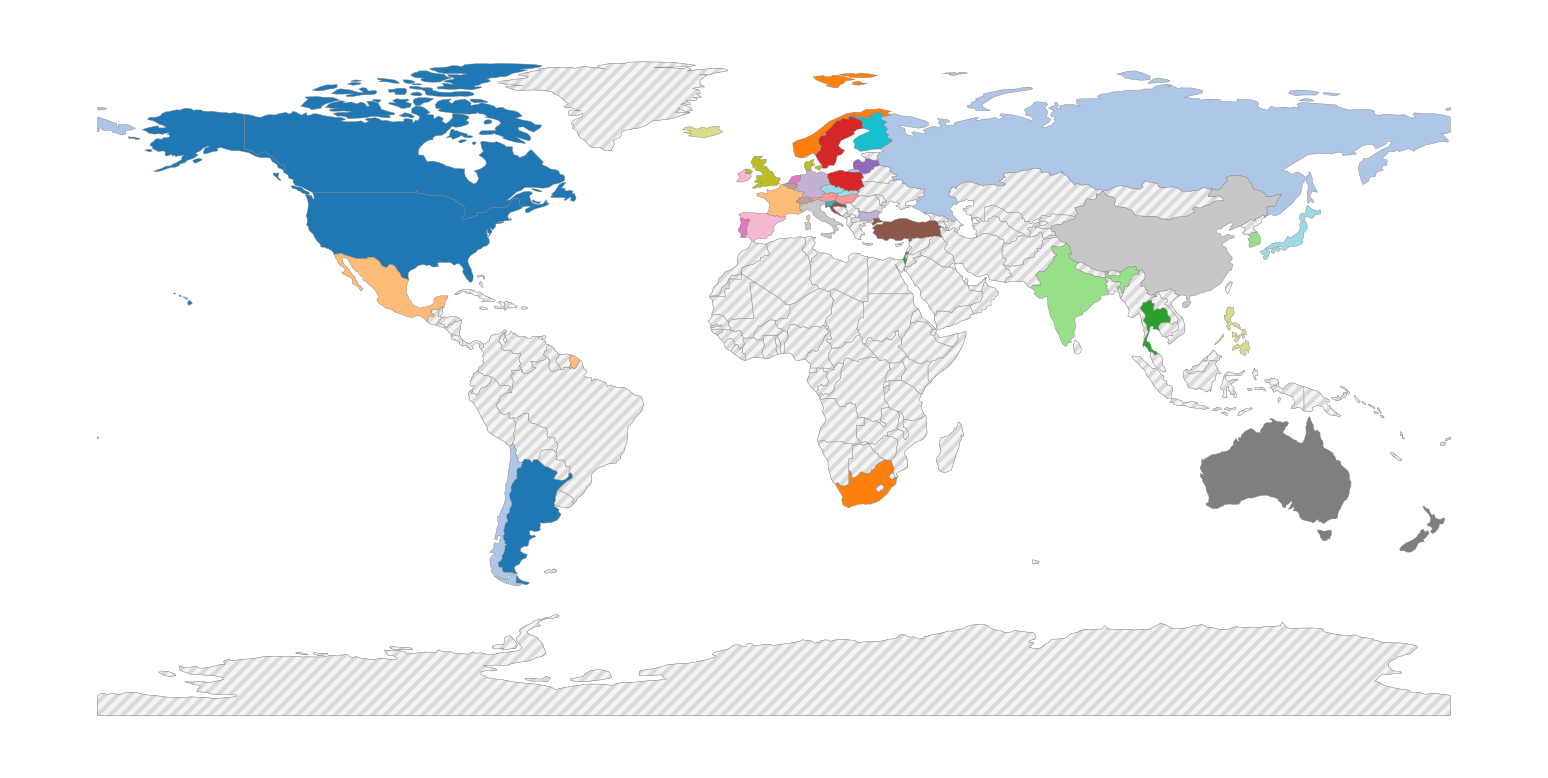

In [90]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.dpi' : 300,
                     'mathtext.fontset' : 'stix', 
                     'font.family' : 'STIXGeneral'
                    })

fig, ax = plt.subplots()
worldmap.query("in_issp_1993 == True or in_issp_2000 == True or in_issp_2010 == True or in_issp_2020 == True").plot(cmap="tab20", edgecolor="grey", linewidth=0.1, ax=ax)
worldmap.query("in_issp_1993 == False and in_issp_2000 == False and in_issp_2010 == False and in_issp_2020 == False").plot(color=[1,1,1], edgecolor="gray", linewidth=0.1, hatch="////////", ax=ax)
worldmap.query("in_issp_1993 == False and in_issp_2000 == False and in_issp_2010 == False and in_issp_2020 == False").plot(edgecolor="gray", linewidth=0.1, color=[0.95,0.95,0.95], alpha=0.8, ax=ax)
plt.axis("off");

In [91]:
worldmap.to_pickle("Processed_Data/misc/worldmap.pickle")